# PyTorch RNN Tutorial
Here we will follow [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

We will do some simple data processing and language classification using an RNN.

In [1]:
import math, os, random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

try:  __set_jtplot__('dark')
except:  pass

## Prepare data
### Download

In [2]:
if not os.path.isdir('data/names'):
  import urllib.request, zipfile
  
  print('Downloading files...', end=' ')
  urllib.request.urlretrieve('https://download.pytorch.org/tutorial/data.zip', 'data.zip')
  
  print('unzipping to data directory...', end=' ')
  with zipfile.ZipFile('data.zip', 'r') as f:
    f.extractall('.')
  os.remove('data.zip')
  
  print('Done!')

else:
  print('Using existing data.')

Using existing data.


In [3]:
# Names in different languages
%ls data/names

Arabic.txt   English.txt  Irish.txt     Polish.txt      Spanish.txt
Chinese.txt  French.txt   Italian.txt   Portuguese.txt  Vietnamese.txt
Czech.txt    German.txt   Japanese.txt  Russian.txt
Dutch.txt    Greek.txt    Korean.txt    Scottish.txt


### Create a list of names for each language in ASCII characters

In [4]:
from easydict import EasyDict as edict
import glob, string, unicodedata

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(f'Number of letters: {n_letters}')

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
  )
print(f'Ślusàrski => {unicodeToAscii("Ślusàrski")}')

# Build the category_lines dictionary, a list of names per language
category_lines = edict()
all_categories = []

for fname in glob.glob('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(fname))[0]
  all_categories.append(category)
  
  with open(fname, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')  # split into lines
  category_lines[category] = [unicodeToAscii(l) for l in lines]

n_categories = len(all_categories)
print(f'Number of categories: {n_categories}')
print(f'Italian names (5): {category_lines.Italian[:5]}')

Number of letters: 57
Ślusàrski => Slusarski
Number of categories: 18
Italian names (5): ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Encoding letters into PyTorch
In this tutorial one-hot encoding is used. Are there better encoding methods?

In [5]:
def lineToTensor(line):
  tensor = torch.zeros(len(line), n_letters)
  for i, letter in enumerate(line):
    tensor[i][all_letters.find(letter)] = 1
  return tensor

dummy = edict(name='Jones')
dummy.tensor = lineToTensor(dummy.name)
print(f'{dummy.name} tensor size: {dummy.tensor.size()}')
print(f'{dummy.name} tensor rowsum: {dummy.tensor.sum(axis=1).squeeze()}')

Jones tensor size: torch.Size([5, 57])
Jones tensor rowsum: tensor([1., 1., 1., 1., 1.])


## Creating the network

In [6]:
Identity = lambda x: x

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size,
               hidden_nonlin = Identity, 
               output_nonlin = nn.LogSoftmax(dim=0)):
    super(RNN, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    # h <- f(Wh*h + Wi*x + bh),  y <- g(Vh*h + bo)
    self.Wh = nn.Linear(hidden_size, hidden_size)
    self.Wi = nn.Linear(input_size, hidden_size, bias=False)
    self.Vh = nn.Linear(hidden_size, output_size)
    self.nonlin_h = hidden_nonlin
    self.nonlin_o = output_nonlin
    
    self.init_hidden()
    
  def forward(self, input):
    self.hidden = self.nonlin_h( self.Wh(self.hidden) + self.Wi(input) )
    output = self.nonlin_o( self.Vh(self.hidden) )
    return output
  
  def init_hidden(self):
    self.hidden = torch.zeros(self.hidden_size)
  
  
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Output size: torch.Size([18])
Hidden size: torch.Size([128])


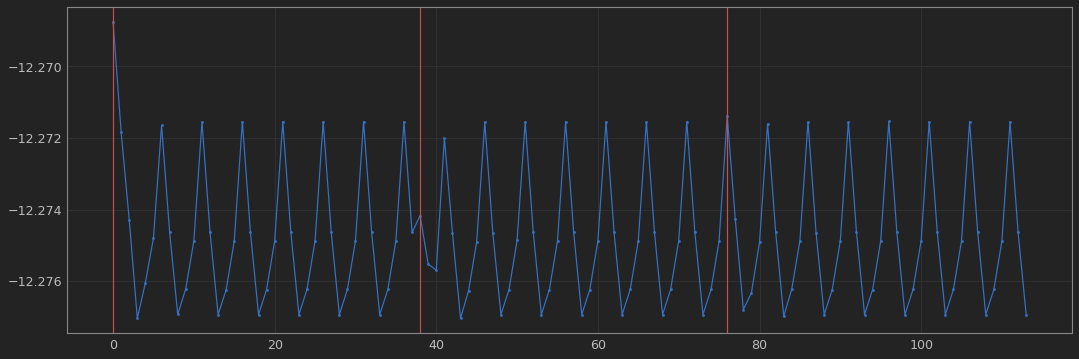

In [7]:
# Demo
with torch.no_grad():
  print(f'Output size: {rnn(dummy.tensor[0]).size()}')
  print(f'Hidden size: {rnn.hidden.size()}')

  dummy.name_len = len(dummy.name)
  reset_interval = 38 #10 * dummy.name_len
  outputs = []
  for i in range(3*reset_interval):
    if i % reset_interval == 0:  rnn.init_hidden()
    outputs.append(rnn(dummy.tensor[i % dummy.name_len]))

outputs = torch.stack(outputs)

plt.figure(figsize=(18,6));
plt.plot(outputs.sum(axis=1)/math.sqrt(outputs.size()[1]), marker='.');
for i in range(0,len(outputs),reset_interval):
  plt.axvline(x=i, color='r');

# Define a way to get category from output, and get training samples

In [8]:
def categoryFromOutput(output):
  _, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

In [9]:
def randomTrainingExample():
  randomChoice = lambda l: l[random.randint(0, len(l)-1)]
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)

category = Korean / line = Nam
category = Dutch / line = Venne
category = Dutch / line = Mooren
category = German / line = Gwerder
category = French / line = Legrand
category = Spanish / line = Quiros
category = Russian / line = Tihobaev
category = Scottish / line = Shaw
category = French / line = Belrose
category = Irish / line = Brian


# Training

In [10]:
criterion = nn.NLLLoss()  # negative log likelihood loss
learning_rate = 5e-3

def training_step(rnn, category_tensor, line_tensor):
  rnn.init_hidden()
  rnn.zero_grad()
  
  for char_tensor in line_tensor:
    output = rnn(char_tensor)
    
  loss = criterion(torch.stack([output]), category_tensor)
  loss.backward()  # compute gradients
  
  for p in rnn.parameters():
    p.data.add_(-learning_rate * p.grad.data)  # just use SGD
    
  return output, loss.item()

In [11]:
import time

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

n_iters = int(1e5)
print_every = int(5e3)
plot_every = int(1e3)

current_loss = 0
all_losses = []
startTime = time.time()
for iter in range(1, n_iters+1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = training_step(rnn, category_tensor, line_tensor)
  current_loss += loss

  # Print iter number, loss, name and guess
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print(f'{iter} {"{:.1f}".format(iter/n_iters*100)}% ({timeSince(startTime)})'
          + ' {:.4f} {} / {} {}'.format(loss, line, guess, correct))

  # Add current loss avg to list of losses
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5.0% (0m 9s) 2.0536 O'Neal / Irish ✓
10000 10.0% (0m 18s) 1.3630 Oinuma / Japanese ✓
15000 15.0% (0m 28s) 3.6749 Seto / Italian ✗ (Chinese)
20000 20.0% (0m 38s) 0.0894 Koulaxizis / Greek ✓
25000 25.0% (0m 47s) 0.8663 Kuang / Chinese ✓
30000 30.0% (0m 56s) 2.7144 Corraidhin / Russian ✗ (Irish)
35000 35.0% (1m 5s) 0.8484 Rebka / Czech ✓
40000 40.0% (1m 15s) 1.8095 Golosenin / Irish ✗ (Russian)
45000 45.0% (1m 24s) 0.0035 Kozlowski / Polish ✓
50000 50.0% (1m 34s) 0.7885 Ho / Korean ✓
55000 55.0% (1m 43s) 2.4767 Janda / Czech ✗ (Polish)
60000 60.0% (1m 53s) 0.6894 Starek / Polish ✓
65000 65.0% (2m 1s) 2.1432 Blazejovsky / Russian ✗ (Czech)
70000 70.0% (2m 10s) 1.6011 Zamorano / Italian ✗ (Spanish)
75000 75.0% (2m 19s) 3.4800 Chung / Korean ✗ (Vietnamese)
80000 80.0% (2m 29s) 0.0029 Teterichev / Russian ✓
85000 85.0% (2m 38s) 0.4548 Asghar / Arabic ✓
90000 90.0% (2m 47s) 2.1222 Maille / Scottish ✗ (Irish)
95000 95.0% (2m 56s) 0.6343 Hirasi / Japanese ✓
100000 100.0% (3m 6s) 0.0058 Bakh

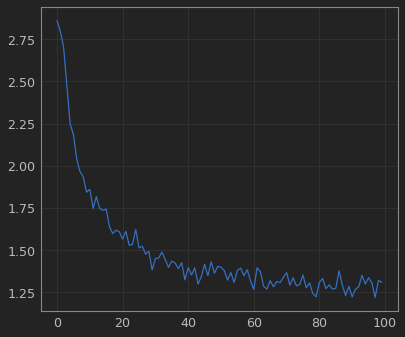

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure();
plt.plot(all_losses);

# Evaluating the model

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
  rnn.init_hidden()
  with torch.no_grad():
    for char_tensor in line_tensor:
      output = rnn(char_tensor)
  return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
confusion.T.div_(confusion.sum(axis=1))

tensor([[0.5164, 0.0056, 0.0000, 0.0173, 0.0345, 0.0361, 0.0843, 0.0017, 0.0382,
         0.0000, 0.0000, 0.0019, 0.1462, 0.0000, 0.0000, 0.0000, 0.0363, 0.0213],
        [0.0181, 0.6767, 0.0000, 0.0000, 0.0907, 0.0379, 0.0056, 0.0968, 0.0036,
         0.0105, 0.0993, 0.1959, 0.0285, 0.0000, 0.0000, 0.0240, 0.0267, 0.0155],
        [0.0049, 0.0000, 0.8274, 0.0000, 0.0036, 0.0120, 0.0056, 0.0034, 0.0018,
         0.0000, 0.0000, 0.0000, 0.0053, 0.1016, 0.1081, 0.0000, 0.0076, 0.0058],
        [0.0000, 0.0075, 0.0000, 0.7611, 0.0054, 0.1394, 0.0150, 0.0390, 0.0109,
         0.0070, 0.0000, 0.0056, 0.0053, 0.0000, 0.0000, 0.0000, 0.0095, 0.0232],
        [0.0576, 0.0207, 0.0000, 0.0405, 0.5771, 0.0671, 0.1592, 0.0102, 0.1036,
         0.0000, 0.0116, 0.0429, 0.1390, 0.0000, 0.0058, 0.0111, 0.0954, 0.0445],
        [0.0033, 0.0056, 0.0000, 0.0539, 0.0145, 0.2754, 0.0749, 0.0085, 0.0891,
         0.0087, 0.0215, 0.0075, 0.0321, 0.0193, 0.0039, 0.0000, 0.0095, 0.0174],
        [0.0312, 0.000

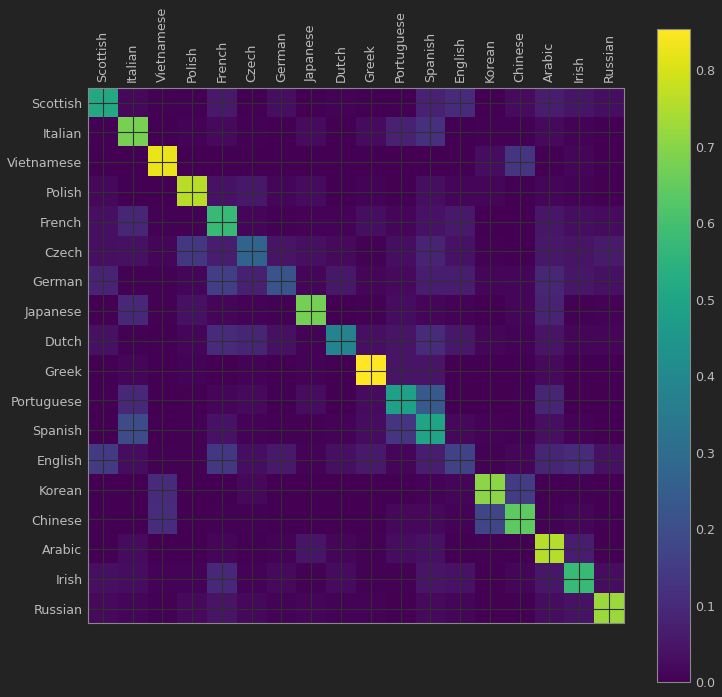

In [14]:
# Set up plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
def predict(input_line, n_predictions=3):
  print(f'\n> {input_line}')
  output = torch.exp(evaluate(lineToTensor(input_line)))

  # Get top N categories
  predictions = []
  for value, cat_idx in zip(*output.topk(n_predictions)):
    predictions.append([value.item(), all_categories[cat_idx.item()]])
    print('({:.2f}) {}'.format(*predictions[-1]))

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.73) Russian
(0.18) Czech
(0.05) English

> Jackson
(0.73) Scottish
(0.11) English
(0.07) Russian

> Satoshi
(0.64) Arabic
(0.29) Italian
(0.04) Japanese
